# Moment-Curvature Verification
This notebook is a verification report for the calculation of the Moment-Curvature with "mkappa.py" of the [bmcs_cross_section](https://github.com/bmcs-group/bmcs_cross_section) package.


In [1]:
%matplotlib widget

In [2]:
from bmcs_cross_section.api import MKappa
from bmcs_cross_section.api import ReinfLayer, BarLayer
from bmcs_utils.api import InteractiveWindow
from bmcs_cross_section.cs_design.cs_shape import TShape
import matplotlib.pyplot as plt
from os.path import join
import numpy as np
import sympy as sp
import pandas as pd
import bmcs_utils.api as bu
sp.init_printing()

In [3]:
def plot_mk_ver(mc, ver_data, test_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    mc.plot_mk_and_stress_profile(ax1, ax2)
    k = ver_data[0]
    m = ver_data[1]
    ax1.plot(k, m, c= 'red', label= 'Experiment by ' + test_name)
    ax1.legend()  

def make_mc(form, high_kappa, B, H,
           E_cc, E_ct, mu, eps_cr,
           material_r1, E_r1, z_r1=False, A_r1=False,
           eps_cy=False, eps_cu=False, eps_tu=False,
           f_t_r1=False, f_sy_r1=False, factor_r1=False,
           material_r2=False, z_r2=False, A_r2=False, E_r2=False,
           f_t_r2=False, f_sy_r2=False, factor_r2=False,
           n_m=False, n_kappa=False, slider=False, matrix=False,
           rho=False, v_f=False, omega=False, psi=False, alpha=False, lambda_cu=False, beta_tu=False,
           o=False, zeta=False):
       
    if(eps_cy == False):
        eps_cy = omega * (-eps_cr)
        if(form == 't_section'):
            eps_cy = eps_cy * (-1)
    if(eps_cu == False):
        eps_cu = lambda_cu * (-eps_cr)
        if(form == 't_section'):
            eps_cu = lambda_cu * eps_cr
    if(eps_tu == False):
        eps_tu = beta_tu * eps_cr

    if ((n_m != False) and (n_kappa != False)):
        mc = MKappa(n_m=100, n_kappa=100)
        mc.low_kappa = 0
        mc.high_kappa = 0.00005
    else: mc = MKappa(low_kappa=0, high_kappa=high_kappa)
    
    if (matrix != False):
        mc.cs_design.matrix = matrix
    if (slider != False):
        mc.kappa_slider = slider
    
    if(form=='rectangular'):
        mc.cross_section_shape_.B = B
        mc.cross_section_shape_.H = H
    
    if(form=='t_section'):
        t_shape = TShape(B_f = B, B_w = o*B, H_w = (1-zeta)*H)
#         mc.cross_section_shape = t_shape
#         das läuft so nicht, ich weiss aber nicht warum. Müsste doch so gehen?
    
    if(A_r1 == False):
        if(form=='rectangular'):
            A_r1 = rho * B * alpha * H
        if(form=='t_section'):
            A_r1 = rho * t_shape.get_cs_area()
    
    mc.cs_design.matrix_.trait_set(
        E_cc = E_cc,
        E_ct = E_ct,
        mu = mu,
        eps_cr = eps_cr,
        eps_cy = eps_cy,
        eps_cu = eps_cu,
        eps_tu = eps_tu
    )
    
    if(z_r1 == False):
        z_r1 = H * (1 - alpha)
    
    bl1 = ReinfLayer(name='layer1', z=z_r1, A=A_r1, matmod=material_r1)
    if material_r1 == 'carbon':
        bl1.matmod_.trait_set(E=E_r1,f_t=f_t_r1,factor=factor_r1)
    if material_r1 == 'steel':
        bl1.matmod_.trait_set(E_s=E_r1, f_sy=f_sy_r1)
    mc.cross_section_layout.add_layer(bl1)
    
    if(material_r2!=False):
        bl2 = ReinfLayer(name='layer2', z=z_r2, A=A_r2, matmod=material_r2)
        if material_r2 == 'carbon':
            bl2.matmod_.trait_set(E=E_r2,f_t=f_t_r2,factor=factor_r2)
        if material_r2 == 'steel':
            bl2.matmod_.trait_set(E_s=E_r2, f_sy=f_sy_r2)
        mc.cross_section_layout.add_layer(bl2)
    
    return mc    

def get_data(element1, xlsx_file, k, m, element2=False, k_faktor=False):
    if element2 == False:
        excel_file = join(element1, xlsx_file)
    else: excel_file = join(element1, element2, xlsx_file)
    data = pd.read_excel(excel_file, engine='openpyxl')
    if(k_faktor==False):
        k_faktor = 1
    k = data[k]*k_faktor
    m = data[m]
    ver_data = [k, m]
    
    return ver_data

## 1. Checking the model with its default parameters

In [4]:
mc = MKappa()
bl1 = ReinfLayer(name='steel 1', z=10, A=100, count=2 )
csl = mc.cross_section_layout
csl.add_layer(bl1)

In [5]:
# mc.interact()

## 2. Verification with experimental results

Verification with experimental results from multiple papers using the summarized parameters in Table 3 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)

Notation in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) | Notation in this file
----------- | -----------
$E$      | E_ct
$E_c$   | E_cc
$E_s$ | E_j
$\varepsilon_{cr}$ | eps_cr
$\varepsilon_{cu}$ | eps_cu
$\varepsilon_{tu}$ | eps_tu
$\varepsilon_{cy}$ | eps_cy
$\mu$ | mu
$\gamma$  | E_cc/E_ct
$\omega$  | eps_cy/eps_cr
$\lambda_{cu}$  | eps_cu/eps_cr
$\beta_{tu}$  | eps_tu/eps_cr
$\psi$  | eps_sy_j/eps_cr
$n$  | E_j/E_ct
$\alpha$  | z_j/h
$r$  | A_s_c/A_s_t
$\rho_g$ | A_j[0]/A_c, where A_j[0] must be tension steel area

### Verification with Rectangluar cross sections
In the following verifications, the parameters will be taken from the parameters summary in Table 3 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)
And the following functions is provided to map the params in the format used in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) to the format of the MKappa model

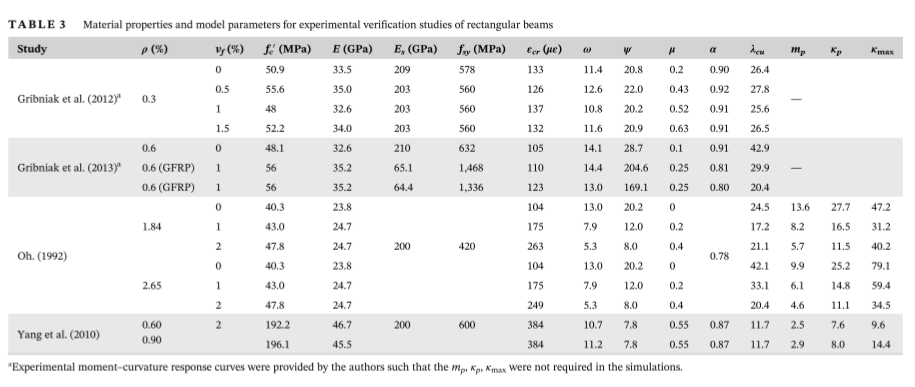

#### 1. Verification with Gribniak et al. (2012), https://doi.org/10.1016/j.engstruct.2012.04.032, Steel reinforcement
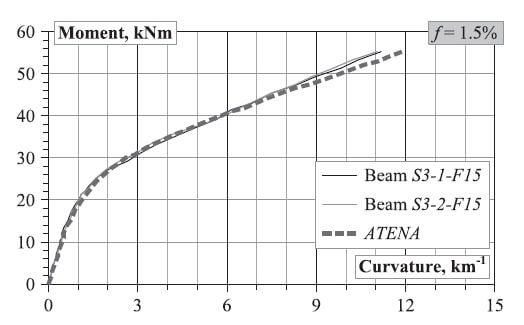

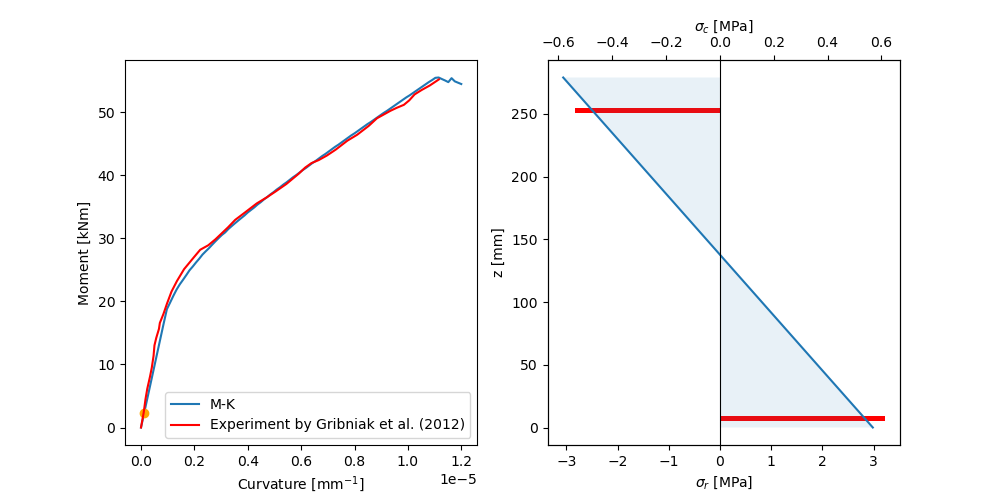

In [6]:
# Beam S3-1-F15
ver_data = get_data(element1='verification_data', xlsx_file='fig_6.xlsx', k='S3_1_F15_Curvature', m='S3_1_F15_Moment', element2='Gribniak2012')
mc = make_mc(form='rectangular', high_kappa=12e-6, B=300, H=279,
             E_cc=34000, E_ct=34000, mu=0.7, eps_cr=0.000132, eps_cy=0.00175, eps_cu=0.0035, eps_tu=0.0023,
             material_r1='steel', z_r1=(279-272), A_r1=235, E_r1=202800, matrix='piecewise linear', f_sy_r1=560,
             material_r2='steel', z_r2=(279-26), A_r2=56, E_r2=202800, f_sy_r2=560)
plot_mk_ver(mc, ver_data, 'Gribniak et al. (2012)')

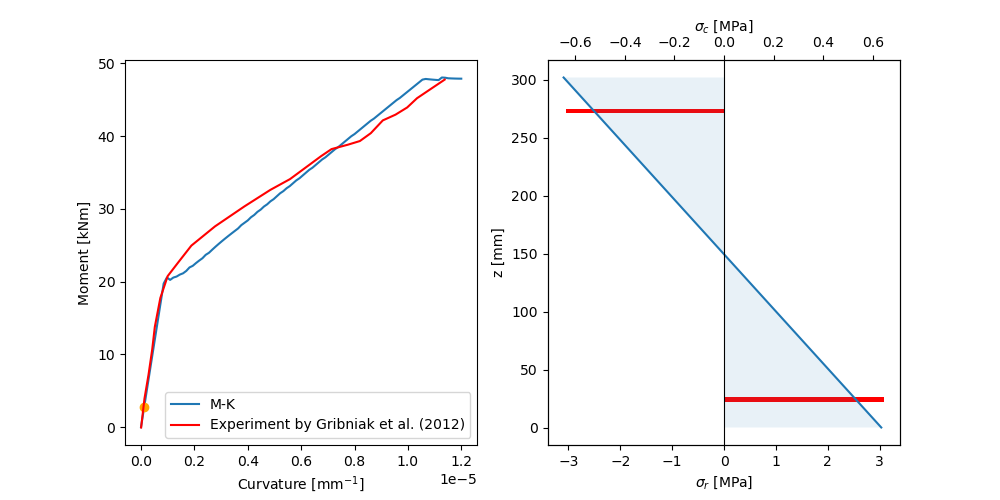

In [7]:
# Beam S3_1_F05
ver_data = get_data(element1='./verification_data/Gribniak2012/', xlsx_file='fig_6.xlsx', k='S3_1_F05_Curvature', m='S3_1_F05_Moment')
mc = make_mc(form='rectangular', high_kappa=12e-6, B=278, H=302,
             E_cc=35000, E_ct=35000, mu=0.42, eps_cr=0.000132, eps_cy=0.00175, eps_cu=0.0035, eps_tu=0.0025,
             material_r1='steel', z_r1=(302-278), A_r1=235, E_r1=202800, matrix='piecewise linear', f_sy_r1=560,
             material_r2='steel', z_r2=(302-29), A_r2=56, E_r2=202800, f_sy_r2=560)
plot_mk_ver(mc, ver_data, 'Gribniak et al. (2012)')

#### 2. Verification with Yang et al. (2010), http://dx.doi.org/10.1016/j.engstruct.2010.07.017, Steel reinforcement
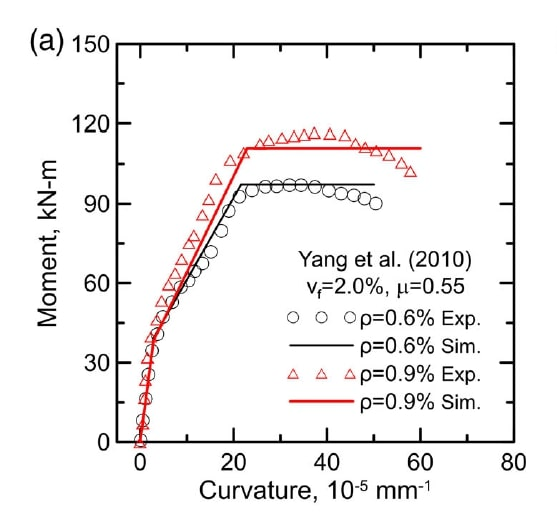

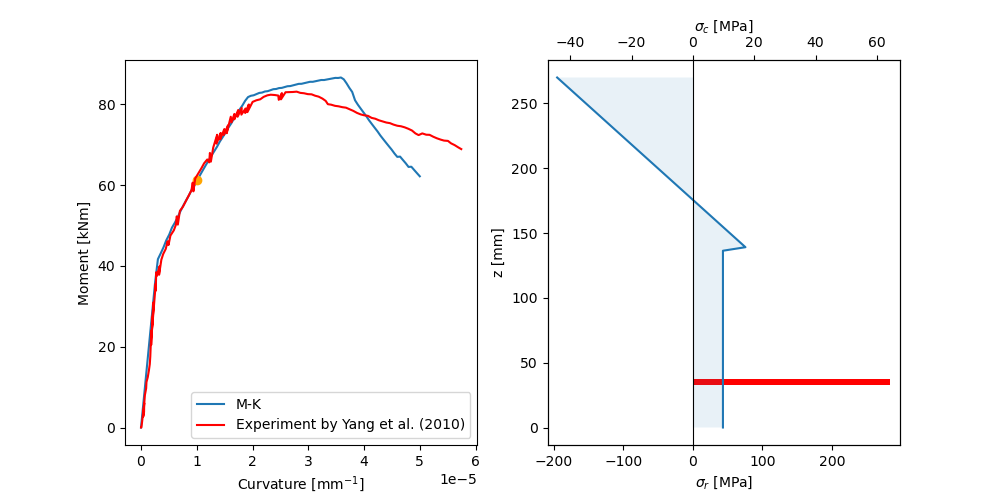

In [8]:
# R12-1,2 (rho = 0.6%)
ver_data = get_data(element1='./verification_data/yang2010', element2='fig_18', xlsx_file='yang2010.xlsx', k='beam_R12_2_Curvature', m='beam_R12_2_Moment')
mc = make_mc(form='rectangular', high_kappa=0.00005, B=180, H=270,
            E_cc=46418, E_ct=46418, mu=0.55, eps_cr=0.000384,
            material_r1='steel', E_r1=200000, f_sy_r1=600,
            n_m=100, n_kappa=100, slider=0.00001,
            rho=0.006, v_f=0.02, omega=10.7, psi=7.8, alpha=0.87, lambda_cu=11.7, beta_tu = 20 )
            # Not sure where beta_tu is from, all other values match Mobasher
            # b = 180, # 180 is the original, Saeed used b = 190
            # E = 46418, # according to Yang paper, according to Mobasher 46700
plot_mk_ver(mc, ver_data, 'Yang et al. (2010)')

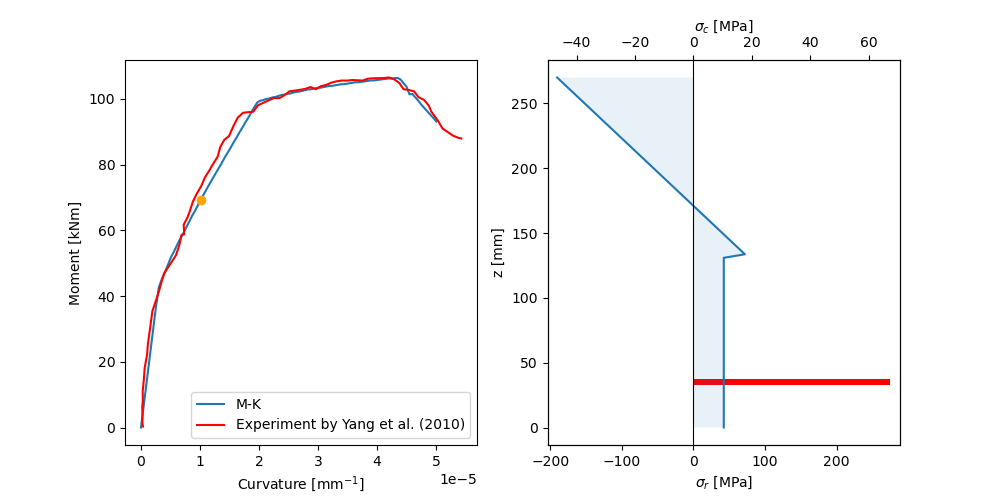

In [9]:
# R13-2 (rho = 0.9%)
ver_data = get_data(element1='./verification_data/yang2010', element2='fig_18', xlsx_file='yang2010.xlsx', k='beam_R13_2_Curvature', m='beam_R13_2_Moment')
mc = make_mc(form='rectangular', high_kappa=0.00005, B=180, H=270,
            E_cc=46680, E_ct=46680, mu=0.58, eps_cr=0.000384,
            material_r1='steel', E_r1=200000, f_sy_r1=600,
            n_m=100, n_kappa=100, slider=0.00001,
            rho=0.009, v_f=0.02, omega=11.2, psi=7.8, alpha=0.87, lambda_cu=11.7, beta_tu = 24 )
            # Not sure where beta_tu is from, all other values match Mobasher
            # E = 46680, according to Yang paper, according to Mobasher 45500
plot_mk_ver(mc, ver_data, 'Yang et al. (2010)')

#### 3. Verification with Von der Heid. et al. (2020), [link](https://www.heringinternational.com/fileadmin/media/archive1/downloads/architekturbeton/Bauingenieur_06_2020_S.210-219.pdf), Carbon reinforcement

In [10]:
# wie besprochen v.d.Heid ignoriert
# HB-SU-0-1 to HB-SU-0-6

# excel_file = join('./verification_data/Von_der_Heid_2020', 'fig.xlsx')
# data = pd.read_excel(excel_file, engine='openpyxl')
# k_data= [data['HB-SU-0-1_Curvature'], data['HB-SU-0-2_Curvature'], 
#          data['HB-SU-0-3_Curvature'], data['HB-SU-0-4_Curvature'], 
#          data['HB-SU-0-5_Curvature'], data['HB-SU-0-6_Curvature']]

# m_data= [data['HB-SU-0-1_Moment'], data['HB-SU-0-2_Moment'],
#          data['HB-SU-0-3_Moment'], data['HB-SU-0-4_Moment'],
#          data['HB-SU-0-5_Moment'], data['HB-SU-0-6_Moment']]
# ver_data = [k_data, m_data]

# # E = 35786.7
# E = 39500

# # from bending test from σ_c,Riss
# # eps_cr = 0.000163
# eps_cr = ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E

# mc = MKappa(low_kappa = 0, high_kappa = 0.0007, n_kappa = 100)
# mc.cs_design.matrix='piecewise linear'
# mc.cs_design.matrix_.trait_set(
#         E_cc=E,
#         E_ct=E,
#         eps_cr=eps_cr,
#         eps_cy=72/E, # 0.0019 from EC2 for C60
#         eps_cu=(72/E)*2, # 0.0029 from EC2 for C60
#         eps_tu=9.02/E,
#         mu=0.0,
#     )

# mc.cross_section_shape_.B = 90
# mc.cross_section_shape_.H = 30
# bl1 = ReinfLayer(name='layer1', z=8, A=2*3.62, matmod='carbon')
# bl2 = ReinfLayer(name='layer2', z=22, A=2*3.62, matmod='carbon')
# bl1.matmod_.trait_set(E=240000, f_t=2712)
# bl2.matmod_.trait_set(E=240000, f_t=2712)
# mc.cross_section_layout.add_layer(bl1)
# mc.cross_section_layout.add_layer(bl2)

# fig, (ax1) = plt.subplots()
# mc.plot_mk(ax1)

# for k, m in zip(k_data, m_data):
#     ax1.plot(k, m, label= 'Exp', alpha=0.2)
    
# ax1.legend()
# # plot_mk_ver(mc, [k_data, m_data], 'Heid. et al. (2020)')

# mc.interact()

#### 3. Verification with Rempel et al. (2020), https://doi.org/10.1002/best.201900086, AR-Glas reinforcement
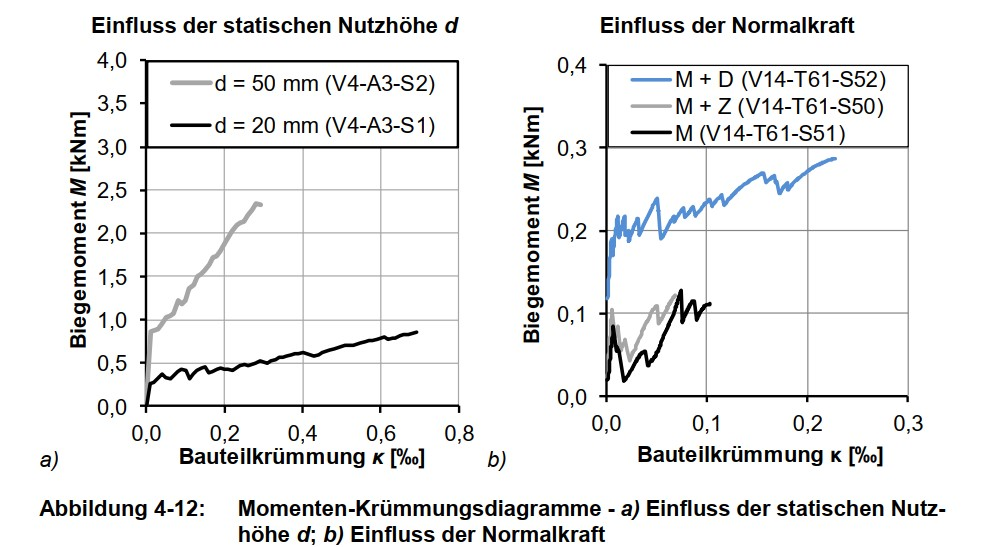

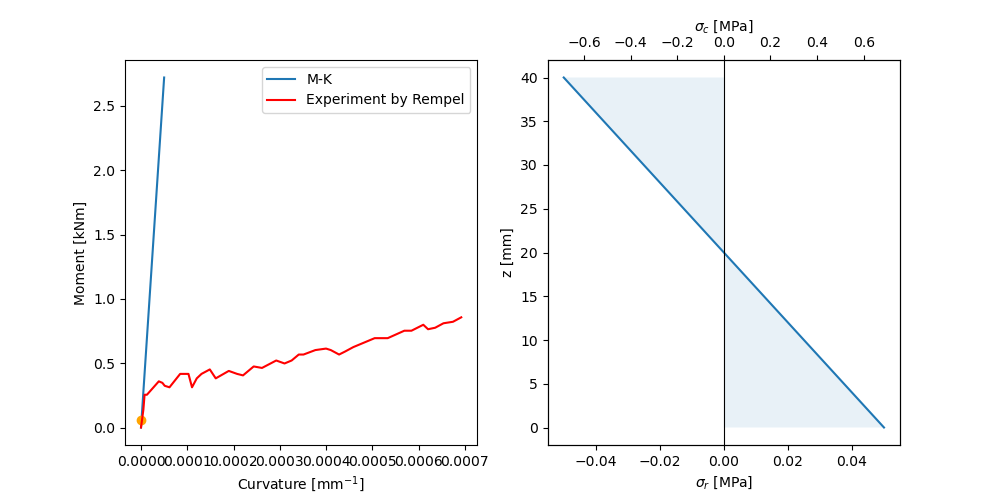

In [11]:
# Leider sieht der Plot nicht aus wie ich erhofft hatte.
# Ich kann nicht nachvolziehen woher die Werte kommen, aus dem Link konnte ich sie so nicht entnehmen.
# Deshalb konnte ich S2 nicht vervollständigen.

# a)
# V4-A3-S1
ver_data = get_data(element1='./verification_data/Rem20/Abbildung_4-12', xlsx_file='rem18_4-12-a.xlsx', k='V4-A3-S1_k', m='V4-A3-S1_m', k_faktor=1e-3)
mc = make_mc(form='rectangular', high_kappa=50e-6, B=300, H=40,
           E_cc=34000, E_ct=34000, mu=0.63, eps_cr=0.0214,
           material_r1='carbon', E_r1=74618, f_t_r1=1599,
           n_m=100, n_kappa=100, slider=0.000001,
           rho=0.003, v_f=0.015, omega=11.6, psi=20.9, alpha=0.91, lambda_cu=26.5, beta_tu=190)
           #beta_tu = 190,  # SUPPOSED because it's missing
           #E_s = 74618, # Kett: 70843
           #f_sy = 1599, #Kett:1590
           #eps_cr = 0.0214, # Kett: 0.0224
plot_mk_ver(mc, ver_data, test_name='Rempel')

# V4-A3-S2
ver_data1 = get_data(element1='./verification_data/Rem20/Abbildung_4-12', xlsx_file='rem18_4-12-a.xlsx', k='V4-A3-S2_k', m='V4-A3-S2_m', k_faktor=1e-3)

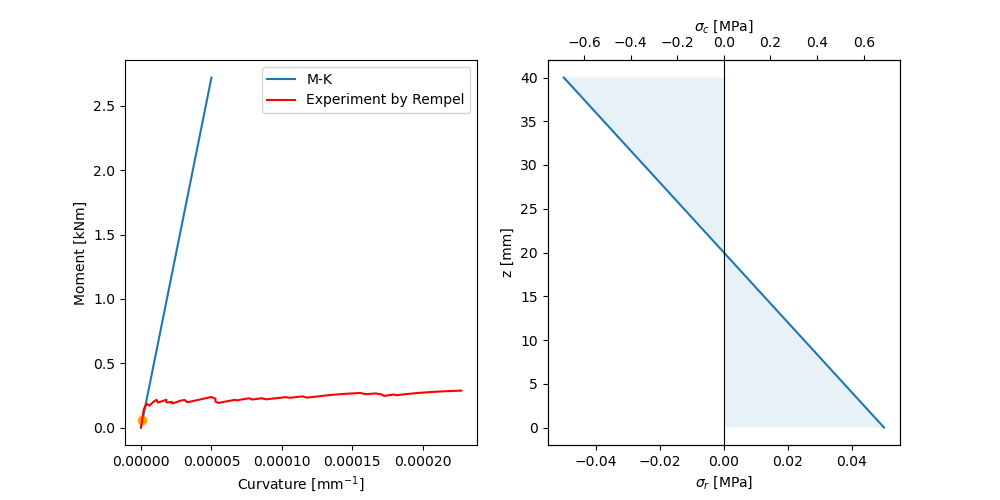

In [12]:
# b)
ver_data_50 = get_data(element1='./verification_data/Rem20/Abbildung_4-12', xlsx_file='rem18_4-12-b.xlsx', k='V14-T61-S50_k', m='V14-T61-S50_m', k_faktor=1e-3)
ver_data_51 = get_data(element1='./verification_data/Rem20/Abbildung_4-12', xlsx_file='rem18_4-12-b.xlsx', k='V14-T61-S51_k', m='V14-T61-S51_m', k_faktor=1e-3)
ver_data_52 = get_data(element1='./verification_data/Rem20/Abbildung_4-12', xlsx_file='rem18_4-12-b.xlsx', k='V14-T61-S52_k', m='V14-T61-S52_m', k_faktor=1e-3)

# V14-T61-S52
# das ist AR-Glas und nicht Carbon?
mc = make_mc(form='rectangular', high_kappa=5e-6, B=300, H=40,
           E_cc=34000, E_ct=34000, mu=0.63, eps_cr=0.0214,
           material_r1='carbon',#!!!
           E_r1=74618, f_t_r1=1599,
           n_m=100, n_kappa=100, slider=0.000001,
           rho=0.003, v_f=0.015, omega=11.6, psi=20.9, alpha=0.91, lambda_cu=26.5, beta_tu=190)
           #beta_tu = 190,  # SUPPOSED because it's missing
           #E_s = 74618, # Kett: 70843
           #f_sy = 1599, #Kett:1590
           #eps_cr = 0.0214, # Kett: 0.0224
plot_mk_ver(mc, ver_data_52, test_name='Rempel')

### Verification with T-sections
In the following verifications, the parameters will be taken from the parameters summary in Table 4 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)
And the following functions is provided to map the params in the format used in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) to the format of the MKappa model

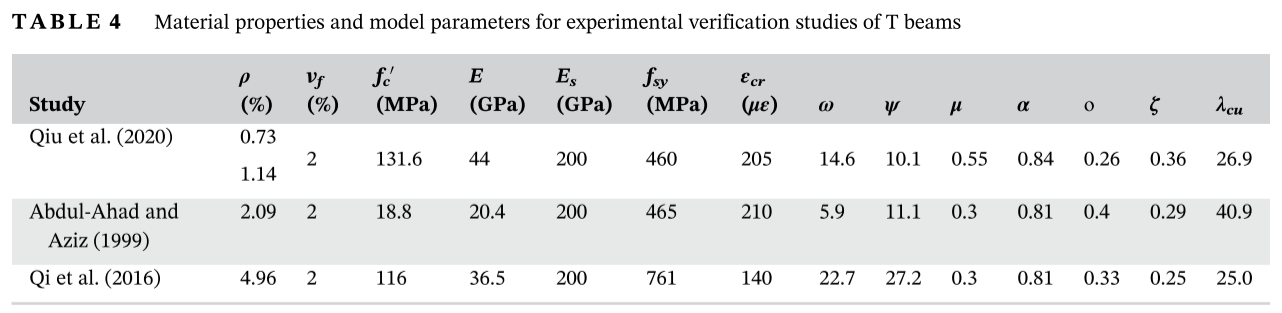

#### 1. Verification with Qiu et al. (2020), https://doi.org/10.1186/s40069-019-0380-x, Steel reinforcement
![Qui_2020.jpg](attachment:Qui_2020.jpg)

In [13]:
#_, (ax_qui) = plt.subplots()

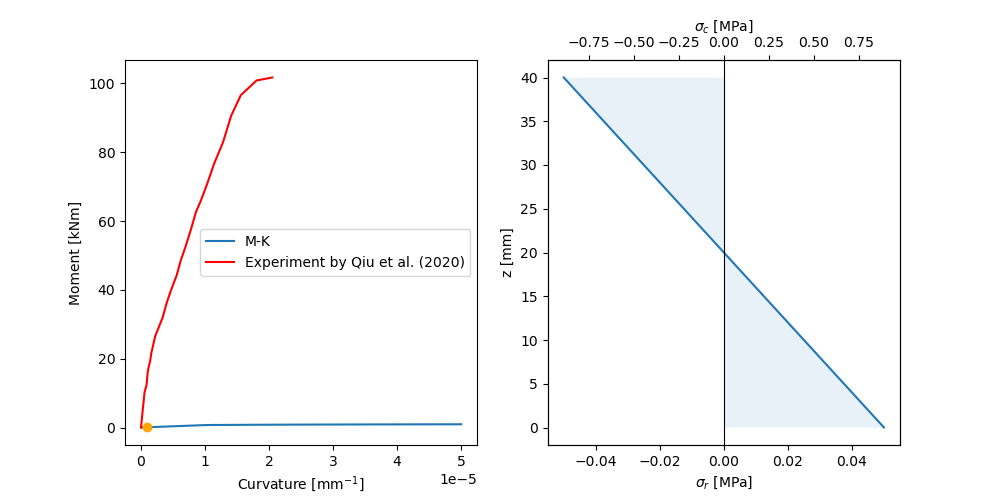

In [14]:
ver_data = get_data(element1='./verification_data/yao20_yao_mobasher/table_4', xlsx_file='qui20.xlsx', k='B-S65-16_k', m='B-S65-16_m', k_faktor=1e-6)
ver_data1 = get_data(element1='./verification_data/yao20_yao_mobasher/table_4', xlsx_file='qui20.xlsx', k='B-S65-20_k', m='B-S65-20_m', k_faktor=1e-6)

# B-S65-16
make_mc(form='t_shape', high_kappa=0.0000175, B=700, H=220,
           E_cc=44000, E_ct=44000, mu=0.55, eps_cr=0.000205,
           material_r1='steel', E_r1=200000, f_t_r1=460,
           n_m=100, n_kappa=100, slider=0.000016,
           rho=0.0073, v_f=0.0, omega=14.6, psi=10.1, alpha=0.84, lambda_cu=26.9, beta_tu=12, o=0.26, zeta = 0.36)
plot_mk_ver(mc, ver_data1, 'Qiu et al. (2020)')

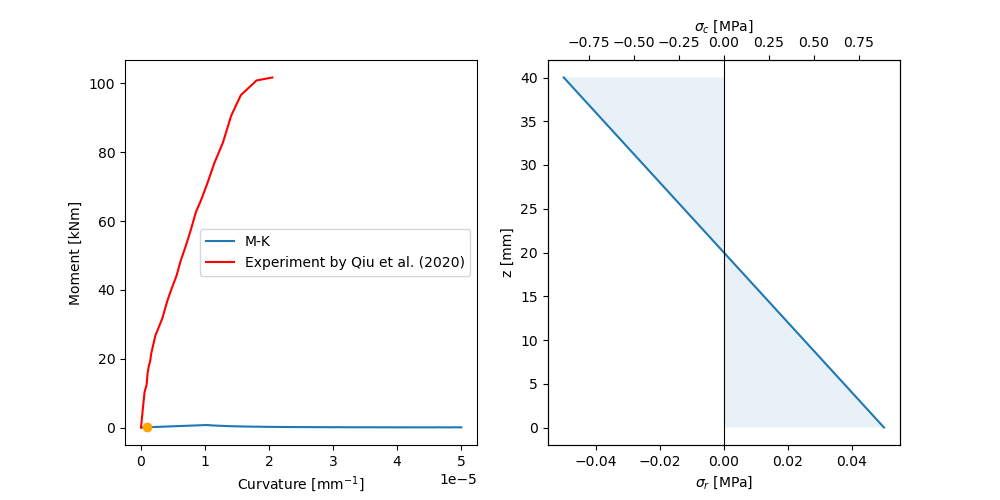

In [15]:
ver_data = get_data(element1='./verification_data/yao20_yao_mobasher/table_4', xlsx_file='qui20.xlsx', k='B-S65-16_k', m='B-S65-16_m', k_faktor=1e-6)
ver_data1 = get_data(element1='./verification_data/yao20_yao_mobasher/table_4', xlsx_file='qui20.xlsx', k='B-S65-20_k', m='B-S65-20_m', k_faktor=1e-6)

make_mc(form='t_shape', high_kappa=0.000015, B=700, H=220,
           E_cc=44000, E_ct=44000, mu=0.00, eps_cr=0.000205,
           material_r1='steel', E_r1=200000, f_t_r1=460,
           n_m=100, n_kappa=100,
           rho=0.0073, v_f=0.0, omega=14.6, psi=10.1, alpha=0.84, lambda_cu=26.9, beta_tu=5, o=0.26, zeta = 0.36)
plot_mk_ver(mc, ver_data1, 'Qiu et al. (2020)')